# Model objects and predicting whole brain activity

Model objects are superEEG's class that contains the model that reconstructs full brain activity timeseries from a smaller sample of electrodes. The superEEG package offers a few premade models that you can use to reconstruct brain activity, but also a way to create your own model if you have a dataset of intracranial patient data converted into the brain object format.  This tutorial will go over how to use the premade models included in this package, as well as make a new model from scratch.

# Load in the required libraries

In [1]:
import superEEG as se
import seaborn as sns
from nilearn import plotting
from nilearn import image

First, let's load in one of the default models.  Below is a model that we made from the pyFR dataset sampled at 20mm resolution.  The 'k10' means that electrodes with a threshold exceeding 10 were removed from the dataset, and 'r20' means that the model uses a radial basis function of with a width of 20 mm to 'fill in' nearby electrode sites during the model creation.

In [2]:
model = se.load('pyFR_k10r20_20mm')
model.info()

Number of locations: 170
Number of subjects: 67
Date created: Fri Aug 11 19:05:13 2017
Meta data: None


## Visualizing the model

The model is comprised of a number of fields.  The most important are the `model.numerator` and `model.denominator`.  Dividing these two fields gives a matrix of z-values, where the value in each cell represents the covariance between every model brain location with every other model brain location. To view the model, simply call the `model.plot` method.  This method wraps `seaborn.heatmap` to plot the model (transformed from z to r), so any arguments that `seaborn.heatmap` accepts are supported by `model.plot`.

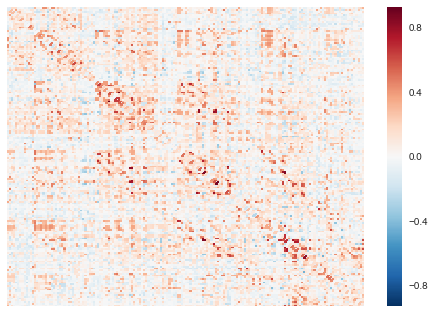

In [3]:
model.plot(xticklabels=False, yticklabels=False)

## Updating the model

Now, let's say we wanted to update the model with a new subjects data.  To do this, we can use the `update` method, passing a new subjects data as a brain object. First, let's load in an example subjects data:

In [4]:
bo = se.load('example_data')
bo.info()

Number of electrodes: 64
Recording time in seconds: [[ 5.  5.]]
Number of sessions: 1
Date created: Fri Aug 11 19:05:14 2017
Meta data: None


and then update the model:

In [5]:
updated_model = model.update(bo)
updated_model.info()

Number of locations: 233
Number of subjects: 68
Date created: Fri Aug 11 19:05:16 2017
Meta data: None


Note that the model is now comprised of 68 subjects, instead of 67 before we updated it.

## Creating a new model

In addition to including a few premade models in the `superEEG` package, we also provide a way to construct a model from scratch.  For example, if you have a dataset of iEEG patients, we provide a way to construct a model that will predict whole brain activity.  The more subjects you include in the model, the better it will be! To create a model, first you'll need to format your subject data into brain objects.  For the purpose of demonstration, we will simulate 10 subjects and construct the model from that data:

In [16]:
n_subs = 10
bos = [se.simulate_bo(sample_rate=1000) for i in range(n_subs)]
bos[0].info()

Number of electrodes: 10
Recording time in seconds: 1
Number of sessions: 1
Date created: Sat Aug 12 10:17:09 2017
Meta data: None


As you can see above, each simulated subject has 10 (randomly placed) 'electrodes', with 1 second of data each. To construct a model from these brain objects, simply pass them to the `se.Model` class, and a new model will be generated:

In [17]:
new_model = se.Model(bos)
new_model.info()

Number of locations: 170
Number of subjects: 10
Date created: Sat Aug 12 10:17:15 2017
Meta data: None


By default, the model is in MNI coordinates with 20mm resolution, but can easily be switched to a different space using some templates we include in the package (Xmm, 8mm, 20mm), or your own custom space (note: the model space MUST be in MNI coordinates).

In [21]:
# new_model = se.Model(bos, template='/your/custom/MNI_template.nii')
# new_model.info()

You can also pass a list (or numpy array) of custom MNI locations to predict:

In [22]:
new_model = se.Model(bos, locs=[[0,0,0],[0,0,1]])
new_model.info()

Number of locations: 2
Number of subjects: 10
Date created: Sat Aug 12 10:27:27 2017
Meta data: None


## Predicting whole brain activity

Now for the magic. `superEEG` uses **_gaussian process regression_** to infer whole brain activity given a smaller sampling of electrode recordings. To predict activity, simply call the `predict` method of a model and pass the subjects brain activity that you'd like to reconstruct:

BEFORE
------
Number of electrodes: 64
Recording time in seconds: [[ 5.  5.]]
Number of sessions: 1
Date created: Fri Aug 11 19:05:14 2017
Meta data: None


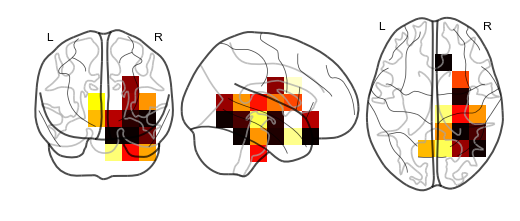

AFTER
------
Number of electrodes: 170
Recording time in seconds: [[ 5.  5.]]
Number of sessions: 1
Date created: Sat Aug 12 10:08:55 2017
Meta data: None


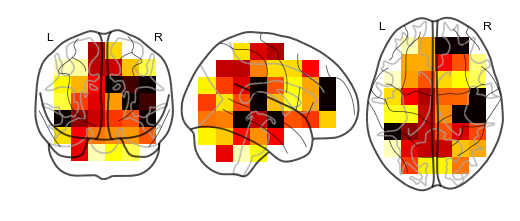

In [12]:
# plot a slice of the original data
print('BEFORE')
print('------')
bo.info()
nii = bo.to_nii()
nii_0 = image.index_img(nii, 1)
plotting.plot_glass_brain(nii_0)
plotting.show()

# voodoo magic
bor = model.predict(bo)

# plot a slice of the whole brain data
print('AFTER')
print('------')
bor.info()
nii = bor.to_nii()
nii_0 = image.index_img(nii, 1)
plotting.plot_glass_brain(nii_0)
plotting.show()

Using the `superEEG` algorithm, we've 'reconstructed' whole brain activity from a smaller sample of electrodes. 